The basic function of this notebook is to take in a STEM image, run it through SingleOrigin, and then do (spatial) statistical analysis on it:
1. Read in a STEM image
2. Create a model of the structure in the image from a cif file
3. Fit the atom columns using SingleOrigin
4. Perform statistical analysis!

First, let's take care of steps 1 through 3 all together:

In [2]:
from importlib import reload
from typing import Literal
import matplotlib
import numpy as np
import tifffile as tif
import SingleOrigin as so
reload(so)
from copy import deepcopy
from abtem_scripts import graphical, analysis_backend
reload(graphical)
reload(analysis_backend)
import quickcrop as qc

C:\Users\charles\.jupyter\venv\lib\site-packages\libpysal\weights\util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [3]:
image_path = graphical.gui_get_path()
image_cropped = np.array(tif.imread(image_path))

## Uncomment the following four lines if the image is not pre-cropped
matplotlib.use("QtAgg")
image_cropped = qc.gui_crop(image_cropped)
image_cropped = so.image_norm(image_cropped)
%matplotlib widget

## Uncomment the following line to enable highpass filtering for the image (implemented in real space)
# _, image_cropped = divide_image_frequencies(image_cropped, s=350, show_images=True)

image_cropped = so.image_norm(image_cropped)

In [4]:
cif_path = graphical.gui_get_path()
uc = so.UnitCell(str(cif_path), origin_shift=[0, 0, 0])
uc.atoms.replace("Ti/O", "Ti/Zr", inplace=True)

za = [1, 0, 0]  # Zone axis direction
a1 = [0, 1, 0]  # Apparent horizontal axis in projection
a2 = [0, 0, 1]  # Most vertical axis in projection

# Ignore light elements for HAADF
uc.project_zone_axis(za, a1, a2, ignore_elements=["O"])
uc.combine_prox_cols(toler=1e-2)

# Uncomment the following line to check this output if changing the u.c.
# uc.plot_unit_cell()

hr_img = so.HRImage(image_cropped)
lattice = hr_img.add_lattice("BZT", uc)

transformed lattice parameters: 
 a1:     4.082 
 a2:     4.082 
 a3:     4.082 
 alpha:  90.0 
 beta:   90.0 
 gamma:  90.0 

Distances (in Angstroms) being combined...
None to combine


Note: the following three cells each have interactive componenets that will time out if they are ignored, so make sure to interact with them right away!

[[572. 521.]
 [521. 452.]]
done selecting 

pick coordinates: [ 988.31 1004.25] 

detected peak coordinates: [989, 1003] 

Creating reference lattice...
Performing rough reference lattice refinement...
Refinement iteration 1
0 min 0.01 sec
Refinement iteration 2
0 min 0.02 sec
Refinement iteration 3
0 min 0.18 sec


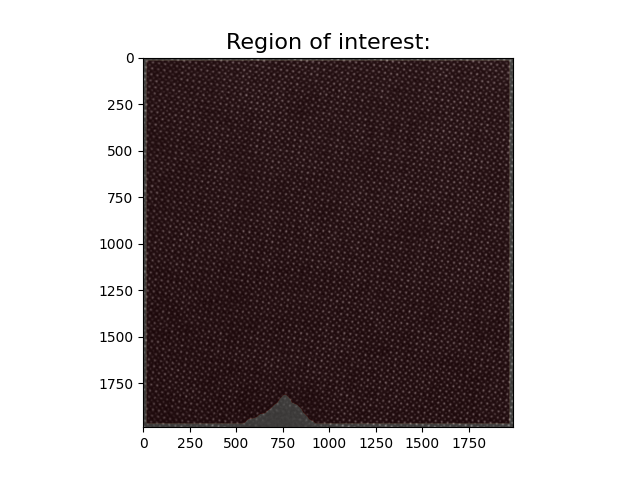

In [10]:
matplotlib.use("QtAgg")
# If some FFT peaks are weak or absent (such as forbidden reflections), specify the order of the first peak that is clearly visible
lattice.fft_get_basis_vect(a1_order=1, a2_order=1, sigma=2)
lattice.define_reference_lattice()
%matplotlib widget
lattice.get_roi_mask_std(r=15, buffer=20, thresh=0.25, show_mask=True)  # Alternative to directly cropping the image in cell 2 if border is irregular
# lattice.roi_mask = np.ones(image_cropped.shape)  # Use this line if the image was pre-cropped or cropped in cell 2

In [23]:
lattice.fit_atom_columns(buffer=10, local_thresh_factor=0.5, use_background_param=True,
                         use_bounds=True, use_circ_gauss=False, parallelize=True,
                         peak_grouping_filter=None)

# Must have only one column per projected unit cell.  If no sublattice meets this criteria,
#  specify a specific column in the projected cell.
lattice.refine_reference_lattice(filter_by='elem', sites_to_use='Ba')

Creating atom column masks...
Step 1(Preparation...): 0 min 1.11 sec
Step 2(fitting masks): 0 min 7.47 sec
Step 3(grouping masks): 0 min 6.80 sec
Step 4(match masks to lattice points): 0 min 0.22 sec
Step 5(check pos errors): 0 min 0.00 sec
Step 6(match masks and points 2): 0 min 0.5 sec
Step 7(Finish prep...): 0 min 0.14 sec
Fitting atom columns...
Using parallel processing


100%|██████████| 6989/6989 [00:09<00:00, 739.82it/s]


Done. Fitting time: 0 min 9.9 sec
Origin shift: [ 0.04175441 -0.11662213]
Optimized basis vectors: [[ 32.30501037   4.83787232]
 [  5.10451947 -32.5327973 ]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: 0.8064 %
Shear component: 0.006983 (radians)
Estimated Pixel Size: 12.446 (pm)


chi-squared of all atom column fits: 4.8505e-04 

R-squared of all atom column fits: 0.935768 



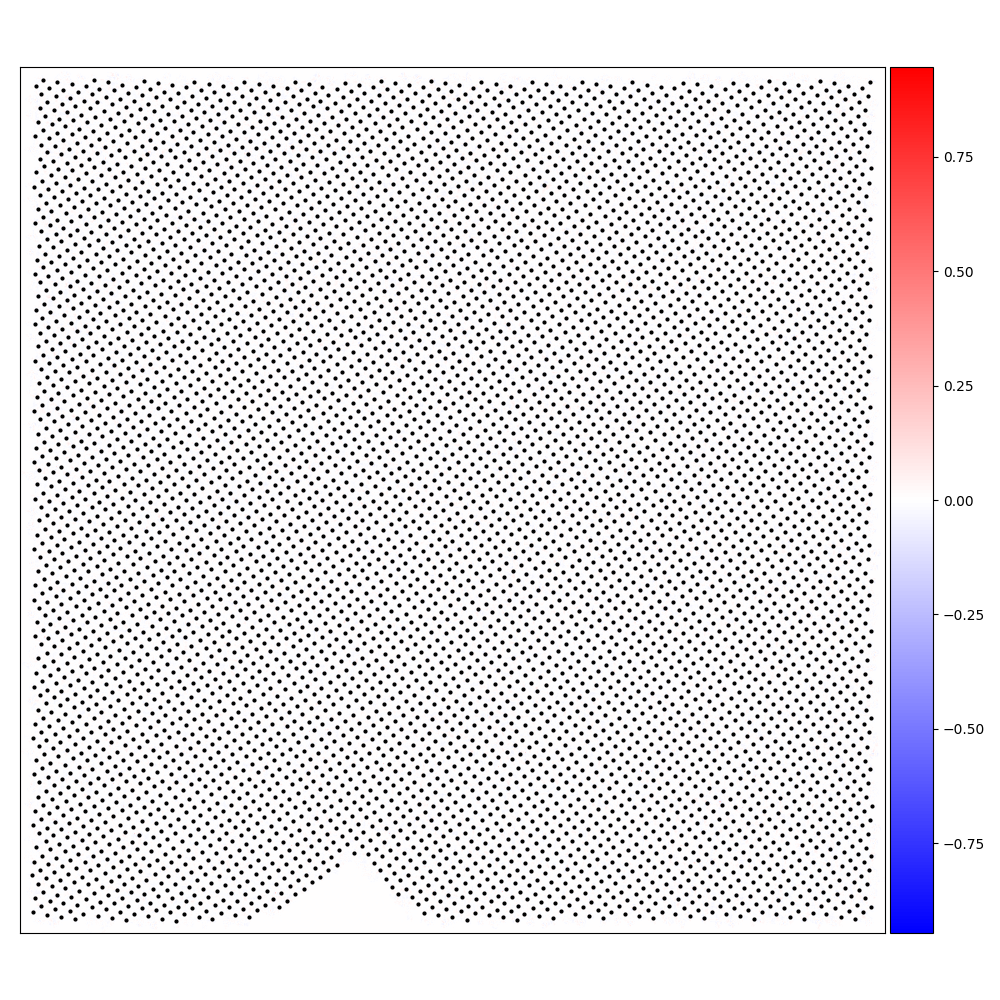

In [24]:
_ = lattice.get_fitting_residuals()  # TODO: Figure out why this isn't using the right colormap (bwr)

(<Figure size 1300x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'Warning: scalebar length is based on the pixel size estimated from the reference lattice. The user should specify the calibrated pixel size if known.'}>)

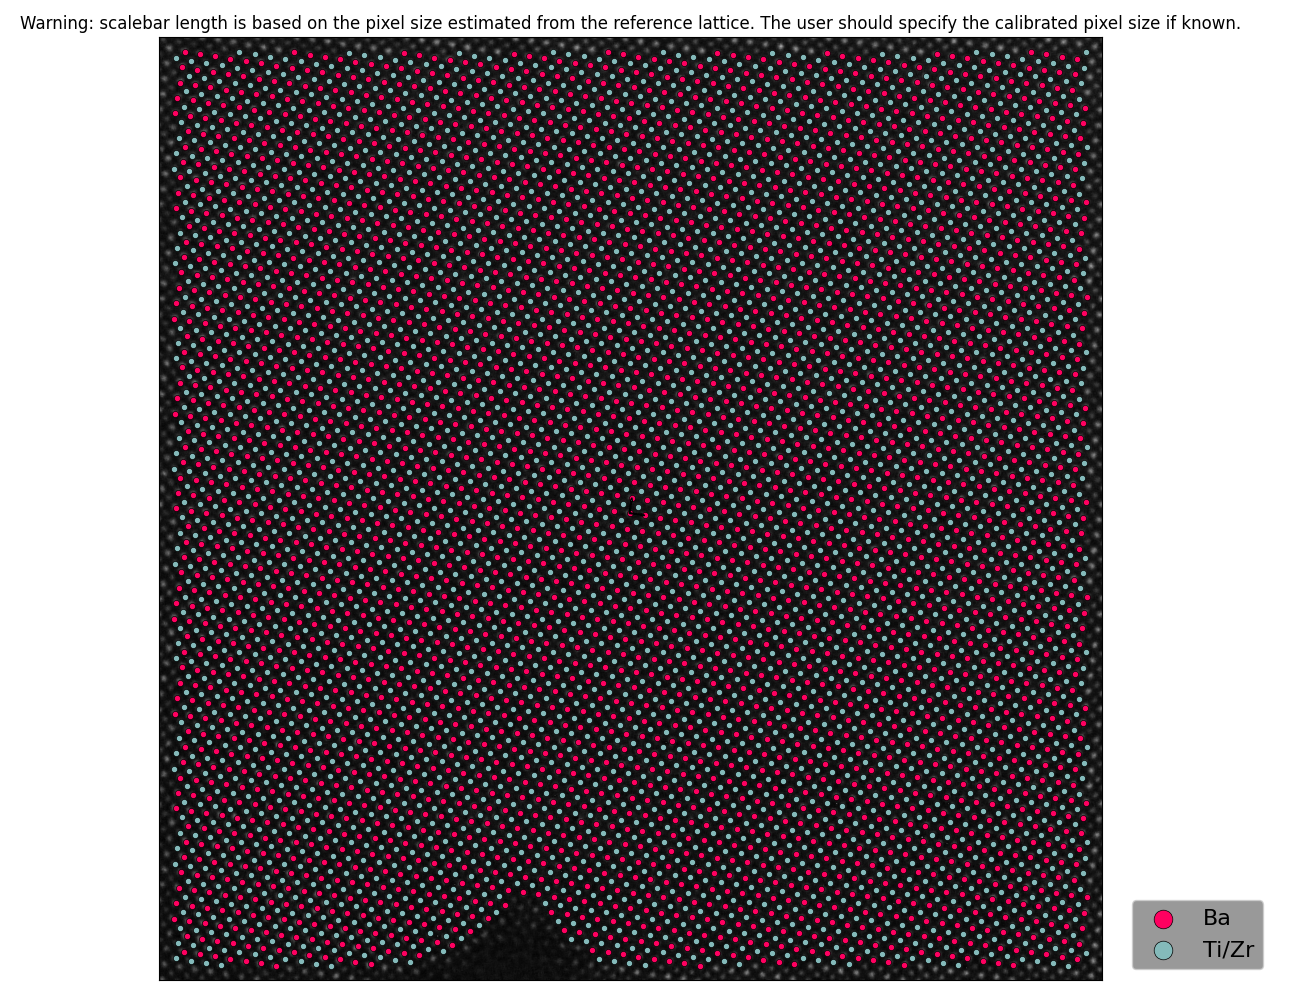

In [25]:
hr_img.plot_atom_column_positions(scatter_kwargs_dict={"s": 20}, scalebar_len_nm=None,
                                  color_dict={"Ba": "#FF0060", "Ti/Zr": "#84BABA"},
                                  outlier_disp_cutoff=100, fit_or_ref="ref")

Displacement statistics for Ti/Zr:
average: 17.59 (pm)
standard deviation: 10.37 (pm)
maximum: 73.05 (pm)
minimum: 0.32 (pm)




(<Figure size 800x800 with 2 Axes>, [<AxesSubplot: >])

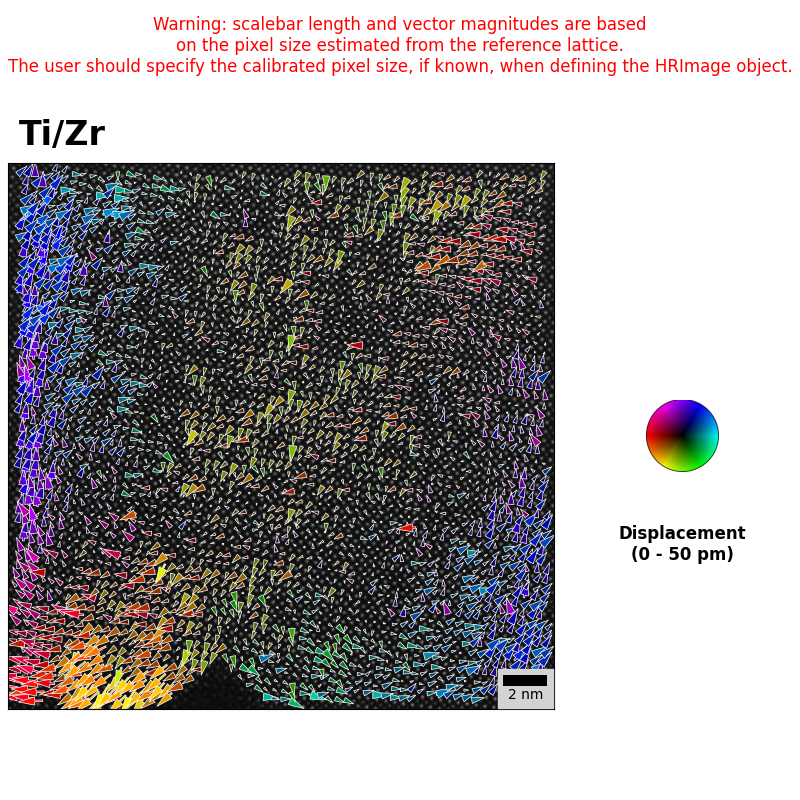

In [26]:
hr_img.plot_disp_vects(sites_to_plot=["Ti/Zr"], arrow_scale_factor=2)

Now we need to wrangle our data into a form that is going to be digestable (and sensical) to the statistical methods provided by pysal.  There is a *lot* going on here.  For the implementation details, check out the functions in `analysis_backend.py`.  Basically:
1. We're making a copy of the  `lattice.at_cols` DataFrame and immediately dropping some columns we won't need; this gives us a more convenient object to work with
2. We need to throw out any (egregious) outliers: sometimes the fitting will leave one or two columns with crazy values for their intensity, and these will badly mess up our analysis, so we discard them
3. We then need to normalize the column intensities, so they fall in the range 0-1.  There are a variety of different ways we can do this, but we need to do it somehow
4. Then we want to discard columns which are irrelevant to our intensity statistics (i.e. columns corresponding to sites which have a different composition); if we compare, for example, Ti/Zr columns to Ba columns, we won't be able to learn anything meaningful about the Ti/Zr columns
5. Step 5 messes up our indexing, so we use a nearest-neighbors search to re-index the remaining columns
6. Next, we'll assign each column its neighborhood (as a mini adjacency list); this neighborhood is used for several things (adding boundary members to clusters when plotting, during the intensity normalization proccess for some methods, and when calculating dispersions from perfect sites),  but importantly it is *not* the same as the neighborhood that is used to calculate the actual statistics
7. Finally, we will calculate the "dispersion" of fitted column positions from their perfect positions; these static shifts are our proxy for polarization

In [32]:
frame = deepcopy(lattice.at_cols)
frame.drop(["site_frac", "x", "y", "weight"], axis=1, inplace=True)  # We don't need these cols
frame.reset_index(drop=True, inplace=True)

analysis_backend.reject_outliers(frame, mode="total_col_int")
analysis_backend.normalize_intensity(frame, lattice.a_2d, n=8, method="global_minmax", kind="Ti/Zr")
analysis_backend.drop_elements(frame, ["Ba"])  # Doing this messes up the indexing in `neighborhood`
# So we'll rebuild the neighborhood in the new indexing
tree = analysis_backend.grow_tree(frame, lattice.a_2d, "Ti/Zr")
frame["neighborhood"] = frame.apply(lambda row: analysis_backend.get_near_neighbors(row, frame, lattice.a_2d, tree, n=8), axis=1)
analysis_backend.disp_calc(frame, normalize=True, kind="Ti/Zr")

Now we can actually do statistics:
1. In the first cell, set the parameters for the analysis to be performed
2. In the second cell, we'll run the analysis and print/plot the results

In [30]:
family: Literal["moran", "geary"] = "moran"
scope: Literal["global", "local"] = "global"
adj_type: Literal["rook", "queen", "king", "bishop", "120"] = "queen"
analysis_variables: list[str] = ["total_col_int"]
permutations: int = 10000
printstats: bool = True
sig: float = 0.05

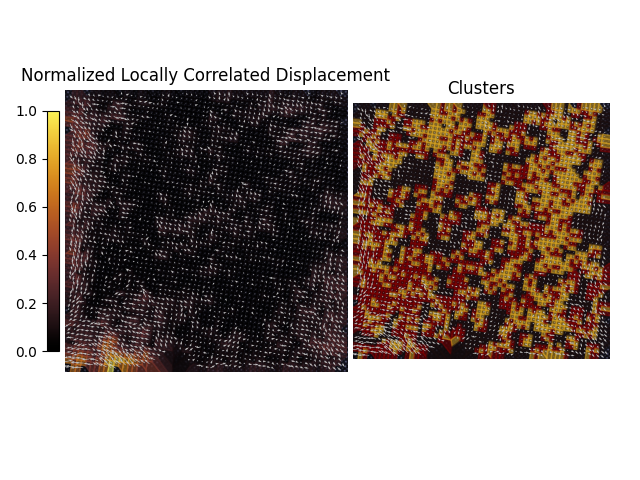

In [31]:
match family:
    case "moran":
        # Moran statistics support exact 1 or 2 variables
        if len(analysis_variables) == 1:
            variation = ""
        elif len(analysis_variables) == 2:
            variation = "_bivariate"
        else:
            raise ValueError("Moran statistics only support exactly 1 or 2 variable")

        kind = f"{family}_{scope}{variation}"
        sts = analysis_backend.get_stats(frame, adj_type, lattice.a_2d, kind, analysis_variables, permutations, printstats)
        analysis_backend.add_stats_to_frame(frame, sts, family)

        if scope == "local":
            # TODO: Plot local clusters
            pass

    case "geary":
        match scope:
            case "global":
                if len(analysis_variables) != 1:
                    raise ValueError("Global Geary statistics only support exactly 1 variable")
                else:
                    variation = ""
            case "local":
                if len(analysis_variables) == 1:
                    variation = ""
                else:
                    variation = "_multivariate"

        # noinspection PyUnboundLocalVariable
        kind = f"{family}_{scope}{variation}"
        sts = analysis_backend.get_stats(frame, adj_type, lattice.a_2d, kind, analysis_variables, permutations, printstats)
        analysis_backend.add_stats_to_frame(frame, sts, family)

        if scope == "local":
            # TODO: Plot local clusters
            pass

    case _:
        raise ValueError("Invalid statistical family: must be either 'moran' or 'geary'")